# Southern Ocean Timeseries

This notebook demonstrates how to using intake-esm to find and load data data from the ACCESS-OM3 `MC_25km_jra_ryf-1.0-beta` test run.

For more information about using intake-esm to find and load data, see:
- the [intake-esm documentation](https://intake-esm.readthedocs.io/en/stable/)
- [this section](https://access-nri-intake-catalog.readthedocs.io/en/latest/usage/quickstart.html#using-an-intake-esm-datastore) of the access-nri-intake-catalog documentation

In [30]:
#This cell must be in all notebooks!
#It allows us to run all the notebooks at once, this cell has a tag "parameters" which allows us to pass in 
# arguments externally using papermill (see mkfigs.sh for details)

### USER EDIT start
# esm_file = "/scratch/ps29/nd0349/access-om3/archive/IC4M8-MCW-100km_jra_ryf/experiment_datastore.json"
esm_file = "/g/data/ps29/nd0349/runs/access-om3/archive/mom6-cice6_ryf_rel/intake_esm_ds.json"
# esm_file = "/g/data/ps29/nd0349/runs/access-om3/archive/IC4M3-MCW-100km_jra_ryf/experiment_datastore.json"
dpi=300
### USER EDIT stop

import os
from matplotlib import rcParams
%matplotlib inline
rcParams["figure.dpi"]= dpi

plotfolder=f"/g/data/{os.environ['PROJECT']}/{os.environ['USER']}/access-om3-paper-figs/"
os.makedirs(plotfolder, exist_ok=True)

 # a similar cell under this means it's being run in batch
print("ESM datastore path: ",esm_file)
print("Plot folder path: ",plotfolder)

ESM datastore path:  /g/data/ps29/nd0349/runs/access-om3/archive/mom6-cice6_ryf_rel/intake_esm_ds.json
Plot folder path:  /g/data/ps29/nd0349/access-om3-paper-figs/


In [31]:
import xarray as xr
import cf_xarray
import intake
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from distributed import Client

In [32]:
client = Client(threads_per_worker=1)
print(client.dashboard_link)

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 39069 instead
  warnings.warn(


/proxy/39069/status


2025-11-21 11:43:56,303 - distributed.scheduler - WARNING - Removing worker 'tcp://127.0.0.1:44789' caused the cluster to lose already computed task(s), which will be recomputed elsewhere: {'_delayed_open_ds-e80fc4ea-27a4-4845-84d2-d1f14b5e27d0', '_delayed_open_ds-a2071b60-b98f-43ce-8477-459c723f60e3', '_delayed_open_ds-2af4329c-ac5a-4a24-b6ed-d1079e3b118e', '_delayed_open_ds-dc5375e9-11ad-43df-9234-316c14832c4a', '_delayed_open_ds-ebb9c614-54a6-4fb2-834a-f433849089e3', '_delayed_open_ds-633bbccb-a4c6-4399-87bd-b8fd801aed2f', '_delayed_open_ds-7dddec8f-b577-458a-9645-e948a53f1d24', '_delayed_open_ds-4e19a78a-e533-479a-9b81-11022298326d', '_delayed_open_ds-1e578529-d6aa-4d80-9405-aac947f70d43', '_delayed_open_ds-19f744b0-cf5b-4f6d-8e71-2c3cba1120dd', '_delayed_open_ds-0ab5c036-62c6-4675-9f9b-70e8522003c4', '_delayed_open_ds-ff986226-5d10-4ba5-b3f7-0faa6f804580', '_delayed_open_ds-9e4b029d-d350-461a-96ca-fed65d61c27b', '_delayed_open_ds-c6e555d2-4556-4c12-a3f2-5761eee71a41', '_delayed_op

### Open the intake-esm datastore

In [33]:
COLUMNS_WITH_ITERABLES = [
        "variable",
        "variable_long_name",
        "variable_standard_name",
        "variable_cell_methods",
        "variable_units"
]

datastore = intake.open_esm_datastore(
    esm_file,
    columns_with_iterables=COLUMNS_WITH_ITERABLES
)


### What ocean variables are available at monthly frequency?

In [34]:
def available_variables(datastore):
    """Return a pandas dataframe summarising the variables in a datastore"""
    variable_columns = [col for col in datastore.df.columns if "variable" in col]
    return (
        datastore.df[variable_columns]
        .explode(variable_columns)
        .drop_duplicates()
        .set_index("variable")
        .sort_index()
    )

In [35]:
datastore_filtered = datastore.search(frequency="1mon", realm="seaIce")
# datastore_filtered = datastore.search(frequency="1mon")

available_variables(datastore_filtered)

,variable_long_name,variable_standard_name,variable_cell_methods,variable_units
variable,,,,
ANGLE,angle grid makes with latitude line on U grid,,,radians
ANGLET,angle grid makes with latitude line on T grid,,,radians
NCAT,category maximum thickness,,,m
Tair_m,air temperature,,time: mean,C
Tsfc_m,snow/ice surface temperature,,time: mean,C
...,...,...,...,...
uvel_m,ice velocity (x),,time: mean,m/s
vatm_m,atm velocity (y),,time: mean,m/s
vicen_m,"ice volume, categories",,time: mean,m


In [36]:
datastore_filtered.unique().variable

['time',
 'time_bounds',
 'NCAT',
 'VGRDi',
 'VGRDs',
 'VGRDb',
 'VGRDa',
 'blkmask',
 'ANGLE',
 'ANGLET',
 'hi_m',
 'hs_m',
 'Tsfc_m',
 'aice_m',
 'uvel_m',
 'vvel_m',
 'uatm_m',
 'vatm_m',
 'sice_m',
 'fswup_m',
 'fswdn_m',
 'flwdn_m',
 'snow_ai_m',
 'rain_ai_m',
 'frzmlt_m',
 'scale_factor_m',
 'fswabs_ai_m',
 'albsni_m',
 'alvdr_ai_m',
 'alidr_ai_m',
 'alvdf_ai_m',
 'alidf_ai_m',
 'albice_m',
 'albsno_m',
 'flat_ai_m',
 'fsens_ai_m',
 'flwup_ai_m',
 'evap_ai_m',
 'Tair_m',
 'congel_m',
 'frazil_m',
 'snoice_m',
 'meltt_m',
 'melts_m',
 'meltb_m',
 'meltl_m',
 'fresh_ai_m',
 'fsalt_m',
 'fsalt_ai_m',
 'fhocn_ai_m',
 'fswthru_ai_m',
 'strairx_m',
 'strairy_m',
 'strtltx_m',
 'strtlty_m',
 'strcorx_m',
 'strcory_m',
 'strocnx_m',
 'strocny_m',
 'strintx_m',
 'strinty_m',
 'strength_m',
 'divu_m',
 'shear_m',
 'vort_m',
 'dvidtt_m',
 'dvidtd_m',
 'daidtt_m',
 'daidtd_m',
 'trsig_m',
 'ice_present_m',
 'fcondtop_ai_m',
 'fmeltt_ai_m',
 'sifb_m',
 'opening_m',
 'aicen_m',
 'vicen_m',
 'f

### Load in monthly data

In [52]:

cice_variables = [
    "aice_m", "hi_m", "congel_m", "frazil_m", "frzmlt_m", "Tair_m", 
    # "fsdrad_m", "wave_sig_ht_m", 
    "meltt_m", "meltb_m", "meltl_m", "dvidtt_m", "daidtt_m" #"snoice_m", 
]
# ds = datastore.search(variable=variables, frequency="1mon").to_dask(
#     xarray_combine_by_coords_kwargs = dict( # These kwargs can make things faster
#         compat="override", data_vars="minimal", coords="minimal",),
#     xarray_open_kwargs = dict(chunks={"yh": -1, "xh": -1}, # Good for spatial operations, but not temporal
#                               decode_timedelta=True,),
# )
# TO-DO: CHECK THE TIME SLICE!
ds_cice = datastore.search(frequency="1mon", variable=cice_variables, realm="seaIce").to_dask().isel(time=slice(0,24))
ds_cice

<xarray.Dataset> Size: 228MB
Dimensions:   (time: 24, nj: 300, ni: 360)
Coordinates:
  * time      (time) object 192B 1900-01-16 12:00:00 ... 1901-12-16 12:00:00
Dimensions without coordinates: nj, ni
Data variables:
    frazil_m  (time, nj, ni) float64 21MB dask.array<chunksize=(1, 150, 180), meta=np.ndarray>
    dvidtt_m  (time, nj, ni) float64 21MB dask.array<chunksize=(1, 150, 180), meta=np.ndarray>
    Tair_m    (time, nj, ni) float64 21MB dask.array<chunksize=(1, 150, 180), meta=np.ndarray>
    frzmlt_m  (time, nj, ni) float64 21MB dask.array<chunksize=(1, 150, 180), meta=np.ndarray>
    meltl_m   (time, nj, ni) float64 21MB dask.array<chunksize=(1, 150, 180), meta=np.ndarray>
    congel_m  (time, nj, ni) float64 21MB dask.array<chunksize=(1, 150, 180), meta=np.ndarray>
    meltb_m   (time, nj, ni) float64 21MB dask.array<chunksize=(1, 150, 180), meta=np.ndarray>
    aice_m    (time, nj, ni) float64 21MB dask.array<chunksize=(1, 150, 180), meta=np.ndarray>
    hi_m      (time, nj, ni) float64 21MB dask.array<chunksize=(1, 150, 180), meta=np.ndarray>
    meltt_m   (time, nj, ni) float64 21MB dask.array<chunksize=(1, 150, 180), meta=np.ndarray>
    daidtt_m  (time, nj, ni) float64 21MB dask.array<chunksize=(1, 150, 180), meta=np.ndarray>
Attributes: (12/20)
    title:                                    access-om3
    contents:                                 Diagnostic and Prognostic Varia...
    source:                                   CICE Sea Ice Model, unknown_ver...
    comment:                                  All years have exactly 365 days
    comment3:                                 seconds elapsed into model date...
    time_period_freq:                         month_1
    ...                                       ...
    intake_esm_attrs:variable_standard_name:  ,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,...
    intake_esm_attrs:variable_cell_methods:   ,,,,,,,,,,time: mean,time: mean...
    intake_esm_attrs:variable_units:          days since 1900-01-01 00:00:00,...
    intake_esm_attrs:realm:                   seaIce
    intake_esm_attrs:_data_format_:           netcdf
    intake_esm_dataset_key:                   access_om3_cice_1mon_mean_XXXX_...

In [53]:
mom_variables = [
    "speed", "mlotst", 
]
# ds_mom = datastore.search(frequency="1mon", variable=mom_variables, realm="ocean").to_dask()
ds_list = []
for var in mom_variables:
    ds_var = datastore.search(
        frequency="1mon",
        variable=var,
        realm="ocean"
    ).to_dask().isel(time=slice(0,24))
    ds_list.append(ds_var)

# Merge into a single Dataset
ds_mom = xr.merge(ds_list)
ds_mom

<xarray.Dataset> Size: 21MB
Dimensions:  (time: 24, yh: 300, xh: 360)
Coordinates:
  * time     (time) object 192B 1900-01-16 12:00:00 ... 1901-12-16 12:00:00
  * yh       (yh) float64 2kB -77.88 -77.63 -77.38 -77.13 ... 88.87 89.32 89.77
  * xh       (xh) float64 3kB -279.5 -278.5 -277.5 -276.5 ... 77.5 78.5 79.5
Data variables:
    speed    (time, yh, xh) float32 10MB dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
    mlotst   (time, yh, xh) float32 10MB dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
Attributes: (12/16)
    NumFilesInSet:                            1
    title:                                    MOM6 diagnostic fields table
    associated_files:                         areacello: access-om3.mom6.h.st...
    grid_type:                                regular
    grid_tile:                                N/A
    intake_esm_vars:                          ['speed']
    ...                                       ...
    intake_esm_attrs:variable_standard_name:  ,,,,,,,,,sea_water_salinity,sea...
    intake_esm_attrs:variable_cell_methods:   ,,,,,,,,,time: mean,time: mean,...
    intake_esm_attrs:variable_units:          ,days since 0001-01-01 00:00:00...
    intake_esm_attrs:realm:                   ocean
    intake_esm_attrs:_data_format_:           netcdf
    intake_esm_dataset_key:                   access_om3_mom6_h_nativeXXXX_XX...

In [54]:
# datastore.search(frequency="1mon", variable=mom_variables, realm="ocean").unique().file_id

In [57]:
mom_variables_daily = ["tos", "sos"]
# ds_mom_daily = datastore.search(frequency="1day", variable=var_list_daily).to_dask().resample(time="1MS").mean()
# ds_mom_daily_monthly = ds_mom_daily_monthly.assign_coords(
#     time = ds_mom_daily_monthly.time + pd.Timedelta(days=15, hours=12)
# )
# ds_mom = esm_datastore.search(frequency=output_frequency, variable=var_list).to_dask()

ds_list_daily = []
for var in mom_variables_daily:
    ds_var = datastore.search(
        frequency="1day",
        variable=var,
        realm="ocean"
    ).to_dask().resample(time="1MS").mean().isel(time=slice(0,24))
    ds_list_daily.append(ds_var)

# Merge into a single Dataset
import cftime
import calendar

years = np.array([t.year for t in ds_cice.time.values])
months = np.array([t.month for t in ds_cice.time.values])
hours = np.array([12 if t.hour >= 12 else 0 for t in ds_cice.time.values])  # preserve your 0/12 pattern

# Create a new list of cftime.DatetimeNoLeap objects
custom_times = [
    cftime.DatetimeNoLeap(y, m, 16, h)  # middle of month, with 0 or 12 hours
    for y, m, h in zip(years, months, hours)
]

ds_mom_daily_monthly = xr.merge(ds_list_daily)
ds_mom_daily_monthly = ds_mom_daily_monthly.assign_coords(time=custom_times)
# ds_mom["time"] = ds_cice.time.to_pandas() #- timedelta(hours=12)
# grid_ds = xr
ds_mom_daily_monthly

<xarray.Dataset> Size: 21MB
Dimensions:  (time: 24, yh: 300, xh: 360)
Coordinates:
  * xh       (xh) float64 3kB -279.5 -278.5 -277.5 -276.5 ... 77.5 78.5 79.5
  * yh       (yh) float64 2kB -77.88 -77.63 -77.38 -77.13 ... 88.87 89.32 89.77
  * time     (time) object 192B 1900-01-16 12:00:00 ... 1901-12-16 12:00:00
Data variables:
    tos      (time, yh, xh) float32 10MB dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
    sos      (time, yh, xh) float32 10MB dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
Attributes: (12/16)
    NumFilesInSet:                            1
    title:                                    MOM6 diagnostic fields table
    associated_files:                         areacello: access-om3.mom6.h.st...
    grid_type:                                regular
    grid_tile:                                N/A
    intake_esm_vars:                          ['tos']
    ...                                       ...
    intake_esm_attrs:variable_standard_name:  ,,,,,,,sea_surface_temperature,...
    intake_esm_attrs:variable_cell_methods:   ,,,,,,area:mean yh:mean xh:mean...
    intake_esm_attrs:variable_units:          degrees_east,degrees_north,days...
    intake_esm_attrs:realm:                   ocean
    intake_esm_attrs:_data_format_:           netcdf
    intake_esm_dataset_key:                   access_om3_mom6_h_sfcXXXX_XX.1day

In [58]:
ds_mom = xr.merge([ds_mom, ds_mom_daily_monthly])
ds_mom = ds_mom.rename({"xh": "ni", "yh": "nj"})
ds_mom

<xarray.Dataset> Size: 45MB
Dimensions:  (time: 26, nj: 300, ni: 360)
Coordinates:
  * time     (time) object 208B 1900-01-16 12:00:00 ... 1901-12-16 12:00:00
  * nj       (nj) float64 2kB -77.88 -77.63 -77.38 -77.13 ... 88.87 89.32 89.77
  * ni       (ni) float64 3kB -279.5 -278.5 -277.5 -276.5 ... 77.5 78.5 79.5
Data variables:
    speed    (time, nj, ni) float32 11MB dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
    mlotst   (time, nj, ni) float32 11MB dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
    tos      (time, nj, ni) float32 11MB dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
    sos      (time, nj, ni) float32 11MB dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
Attributes: (12/16)
    NumFilesInSet:                            1
    title:                                    MOM6 diagnostic fields table
    associated_files:                         areacello: access-om3.mom6.h.st...
    grid_type:                                regular
    grid_tile:                                N/A
    intake_esm_vars:                          ['speed']
    ...                                       ...
    intake_esm_attrs:variable_standard_name:  ,,,,,,,,,sea_water_salinity,sea...
    intake_esm_attrs:variable_cell_methods:   ,,,,,,,,,time: mean,time: mean,...
    intake_esm_attrs:variable_units:          ,days since 0001-01-01 00:00:00...
    intake_esm_attrs:realm:                   ocean
    intake_esm_attrs:_data_format_:           netcdf
    intake_esm_dataset_key:                   access_om3_mom6_h_nativeXXXX_XX...

In [59]:
# ds_cice.time.values

In [60]:

grid_ds = xr.open_dataset('/g/data/vk83/configurations/inputs/access-om3/cice/grids/global.1deg/2024.05.14/grid.nc')
grid_ds

# Add grid to dataset
ds_cice = ds_cice.rename({name: name[:-2] for name in ds_cice.data_vars if name.endswith('_m')})
ds_cice.coords['TLON'] = np.degrees(grid_ds['tlon'])
ds_cice.coords['TLAT'] = np.degrees(grid_ds['tlat'])
ds_cice['tarea'] = grid_ds['tarea']
ds = xr.merge([ds_cice, ds_mom])
ds

<xarray.Dataset> Size: 298MB
Dimensions:  (time: 26, nj: 300, ni: 360)
Coordinates:
  * time     (time) object 208B 1900-01-16 12:00:00 ... 1901-12-16 12:00:00
  * nj       (nj) float64 2kB -77.88 -77.63 -77.38 -77.13 ... 88.87 89.32 89.77
  * ni       (ni) float64 3kB -279.5 -278.5 -277.5 -276.5 ... 77.5 78.5 79.5
    ulat     (nj, ni) float64 864kB ...
    ulon     (nj, ni) float64 864kB ...
    tlat     (nj, ni) float64 864kB -1.359 -1.359 -1.359 ... 1.153 1.145 1.138
    tlon     (nj, ni) float64 864kB -4.878 -4.861 -4.843 ... 1.395 1.396 1.396
    TLON     (nj, ni) float64 864kB -279.5 -278.5 -277.5 ... 79.96 79.97 79.99
    TLAT     (nj, ni) float64 864kB -77.88 -77.88 -77.88 ... 66.04 65.63 65.21
Data variables: (12/16)
    frazil   (time, nj, ni) float64 22MB dask.array<chunksize=(1, 150, 180), meta=np.ndarray>
    dvidtt   (time, nj, ni) float64 22MB dask.array<chunksize=(1, 150, 180), meta=np.ndarray>
    Tair     (time, nj, ni) float64 22MB dask.array<chunksize=(1, 150, 180), meta=np.ndarray>
    frzmlt   (time, nj, ni) float64 22MB dask.array<chunksize=(1, 150, 180), meta=np.ndarray>
    meltl    (time, nj, ni) float64 22MB dask.array<chunksize=(1, 150, 180), meta=np.ndarray>
    congel   (time, nj, ni) float64 22MB dask.array<chunksize=(1, 150, 180), meta=np.ndarray>
    ...       ...
    daidtt   (time, nj, ni) float64 22MB dask.array<chunksize=(1, 150, 180), meta=np.ndarray>
    tarea    (nj, ni) float64 864kB ...
    speed    (time, nj, ni) float32 11MB dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
    mlotst   (time, nj, ni) float32 11MB dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
    tos      (time, nj, ni) float32 11MB dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
    sos      (time, nj, ni) float32 11MB dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
Attributes: (12/20)
    title:                                    access-om3
    contents:                                 Diagnostic and Prognostic Varia...
    source:                                   CICE Sea Ice Model, unknown_ver...
    comment:                                  All years have exactly 365 days
    comment3:                                 seconds elapsed into model date...
    time_period_freq:                         month_1
    ...                                       ...
    intake_esm_attrs:variable_standard_name:  ,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,...
    intake_esm_attrs:variable_cell_methods:   ,,,,,,,,,,time: mean,time: mean...
    intake_esm_attrs:variable_units:          days since 1900-01-01 00:00:00,...
    intake_esm_attrs:realm:                   seaIce
    intake_esm_attrs:_data_format_:           netcdf
    intake_esm_dataset_key:                   access_om3_cice_1mon_mean_XXXX_...

## Integrate over Southern Ocean

In [61]:
southern_ocean_mask = ds['TLAT'] < -60
southern_ocean_mask

ds_so = ds.where(southern_ocean_mask)
ds_so

<xarray.Dataset> Size: 298MB
Dimensions:  (time: 26, nj: 300, ni: 360)
Coordinates:
  * time     (time) object 208B 1900-01-16 12:00:00 ... 1901-12-16 12:00:00
  * nj       (nj) float64 2kB -77.88 -77.63 -77.38 -77.13 ... 88.87 89.32 89.77
  * ni       (ni) float64 3kB -279.5 -278.5 -277.5 -276.5 ... 77.5 78.5 79.5
    ulat     (nj, ni) float64 864kB -1.357 -1.357 -1.357 ... 1.149 1.142 1.134
    ulon     (nj, ni) float64 864kB -4.869 -4.852 -4.835 ... 1.396 1.396 1.396
    tlat     (nj, ni) float64 864kB -1.359 -1.359 -1.359 ... 1.153 1.145 1.138
    tlon     (nj, ni) float64 864kB -4.878 -4.861 -4.843 ... 1.395 1.396 1.396
    TLON     (nj, ni) float64 864kB -279.5 -278.5 -277.5 ... 79.96 79.97 79.99
    TLAT     (nj, ni) float64 864kB -77.88 -77.88 -77.88 ... 66.04 65.63 65.21
Data variables: (12/16)
    frazil   (time, nj, ni) float64 22MB dask.array<chunksize=(1, 150, 180), meta=np.ndarray>
    dvidtt   (time, nj, ni) float64 22MB dask.array<chunksize=(1, 150, 180), meta=np.ndarray>
    Tair     (time, nj, ni) float64 22MB dask.array<chunksize=(1, 150, 180), meta=np.ndarray>
    frzmlt   (time, nj, ni) float64 22MB dask.array<chunksize=(1, 150, 180), meta=np.ndarray>
    meltl    (time, nj, ni) float64 22MB dask.array<chunksize=(1, 150, 180), meta=np.ndarray>
    congel   (time, nj, ni) float64 22MB dask.array<chunksize=(1, 150, 180), meta=np.ndarray>
    ...       ...
    daidtt   (time, nj, ni) float64 22MB dask.array<chunksize=(1, 150, 180), meta=np.ndarray>
    tarea    (nj, ni) float64 864kB 6.41e+08 6.41e+08 6.41e+08 ... nan nan nan
    speed    (time, nj, ni) float32 11MB dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
    mlotst   (time, nj, ni) float32 11MB dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
    tos      (time, nj, ni) float32 11MB dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
    sos      (time, nj, ni) float32 11MB dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
Attributes: (12/20)
    title:                                    access-om3
    contents:                                 Diagnostic and Prognostic Varia...
    source:                                   CICE Sea Ice Model, unknown_ver...
    comment:                                  All years have exactly 365 days
    comment3:                                 seconds elapsed into model date...
    time_period_freq:                         month_1
    ...                                       ...
    intake_esm_attrs:variable_standard_name:  ,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,...
    intake_esm_attrs:variable_cell_methods:   ,,,,,,,,,,time: mean,time: mean...
    intake_esm_attrs:variable_units:          days since 1900-01-01 00:00:00,...
    intake_esm_attrs:realm:                   seaIce
    intake_esm_attrs:_data_format_:           netcdf
    intake_esm_dataset_key:                   access_om3_cice_1mon_mean_XXXX_...

In [62]:
all_variables = cice_variables + mom_variables + mom_variables_daily
all_variables = [name[:-2] if name.endswith('_m') else name for name in all_variables]
all_variables

['aice',
 'hi',
 'congel',
 'frazil',
 'frzmlt',
 'Tair',
 'meltt',
 'meltb',
 'meltl',
 'dvidtt',
 'daidtt',
 'speed',
 'mlotst',
 'tos',
 'sos']

In [63]:
# Create a dictionary of southern ocean timeseries multiplied by area
so_timeseries_dict = {
    var: (ds_so[var] * ds_so['tarea']).sum(dim=['ni','nj']) /
         ds_so['tarea'].sum(dim=['ni','nj'])
    for var in all_variables
}

# Optionally combine into a single xarray Dataset
so_timeseries = xr.Dataset(so_timeseries_dict)
so_timeseries

<xarray.Dataset> Size: 3kB
Dimensions:  (time: 26)
Coordinates:
  * time     (time) object 208B 1900-01-16 12:00:00 ... 1901-12-16 12:00:00
Data variables: (12/15)
    aice     (time) float64 208B dask.array<chunksize=(1,), meta=np.ndarray>
    hi       (time) float64 208B dask.array<chunksize=(1,), meta=np.ndarray>
    congel   (time) float64 208B dask.array<chunksize=(1,), meta=np.ndarray>
    frazil   (time) float64 208B dask.array<chunksize=(1,), meta=np.ndarray>
    frzmlt   (time) float64 208B dask.array<chunksize=(1,), meta=np.ndarray>
    Tair     (time) float64 208B dask.array<chunksize=(1,), meta=np.ndarray>
    ...       ...
    dvidtt   (time) float64 208B dask.array<chunksize=(1,), meta=np.ndarray>
    daidtt   (time) float64 208B dask.array<chunksize=(1,), meta=np.ndarray>
    speed    (time) float64 208B dask.array<chunksize=(1,), meta=np.ndarray>
    mlotst   (time) float64 208B dask.array<chunksize=(1,), meta=np.ndarray>
    tos      (time) float64 208B dask.array<chunksize=(1,), meta=np.ndarray>
    sos      (time) float64 208B dask.array<chunksize=(1,), meta=np.ndarray>

In [64]:
so_timeseries['sia'] = (ds_so['aice'] * ds_so['tarea']).where(ds_so['aice'] > 0.15).sum(dim=['ni','nj'])
so_timeseries['sie'] = (ds_so['tarea']).where(ds_so['aice'] > 0.15).sum(dim=['ni','nj'])
so_timeseries['siv'] = (ds_so['aice'] * ds_so['hi'] * ds_so['tarea']).where(ds_so['aice'] > 0.15).sum(dim=['ni','nj'])

In [65]:
import seaborn as sns
sns.set_theme(style="ticks") 

KeyError: "No variable named 'fsdrad'. Variables on the dataset include ['time', 'aice', 'hi', 'congel', 'frazil', ..., 'tos', 'sos', 'sia', 'sie', 'siv']"

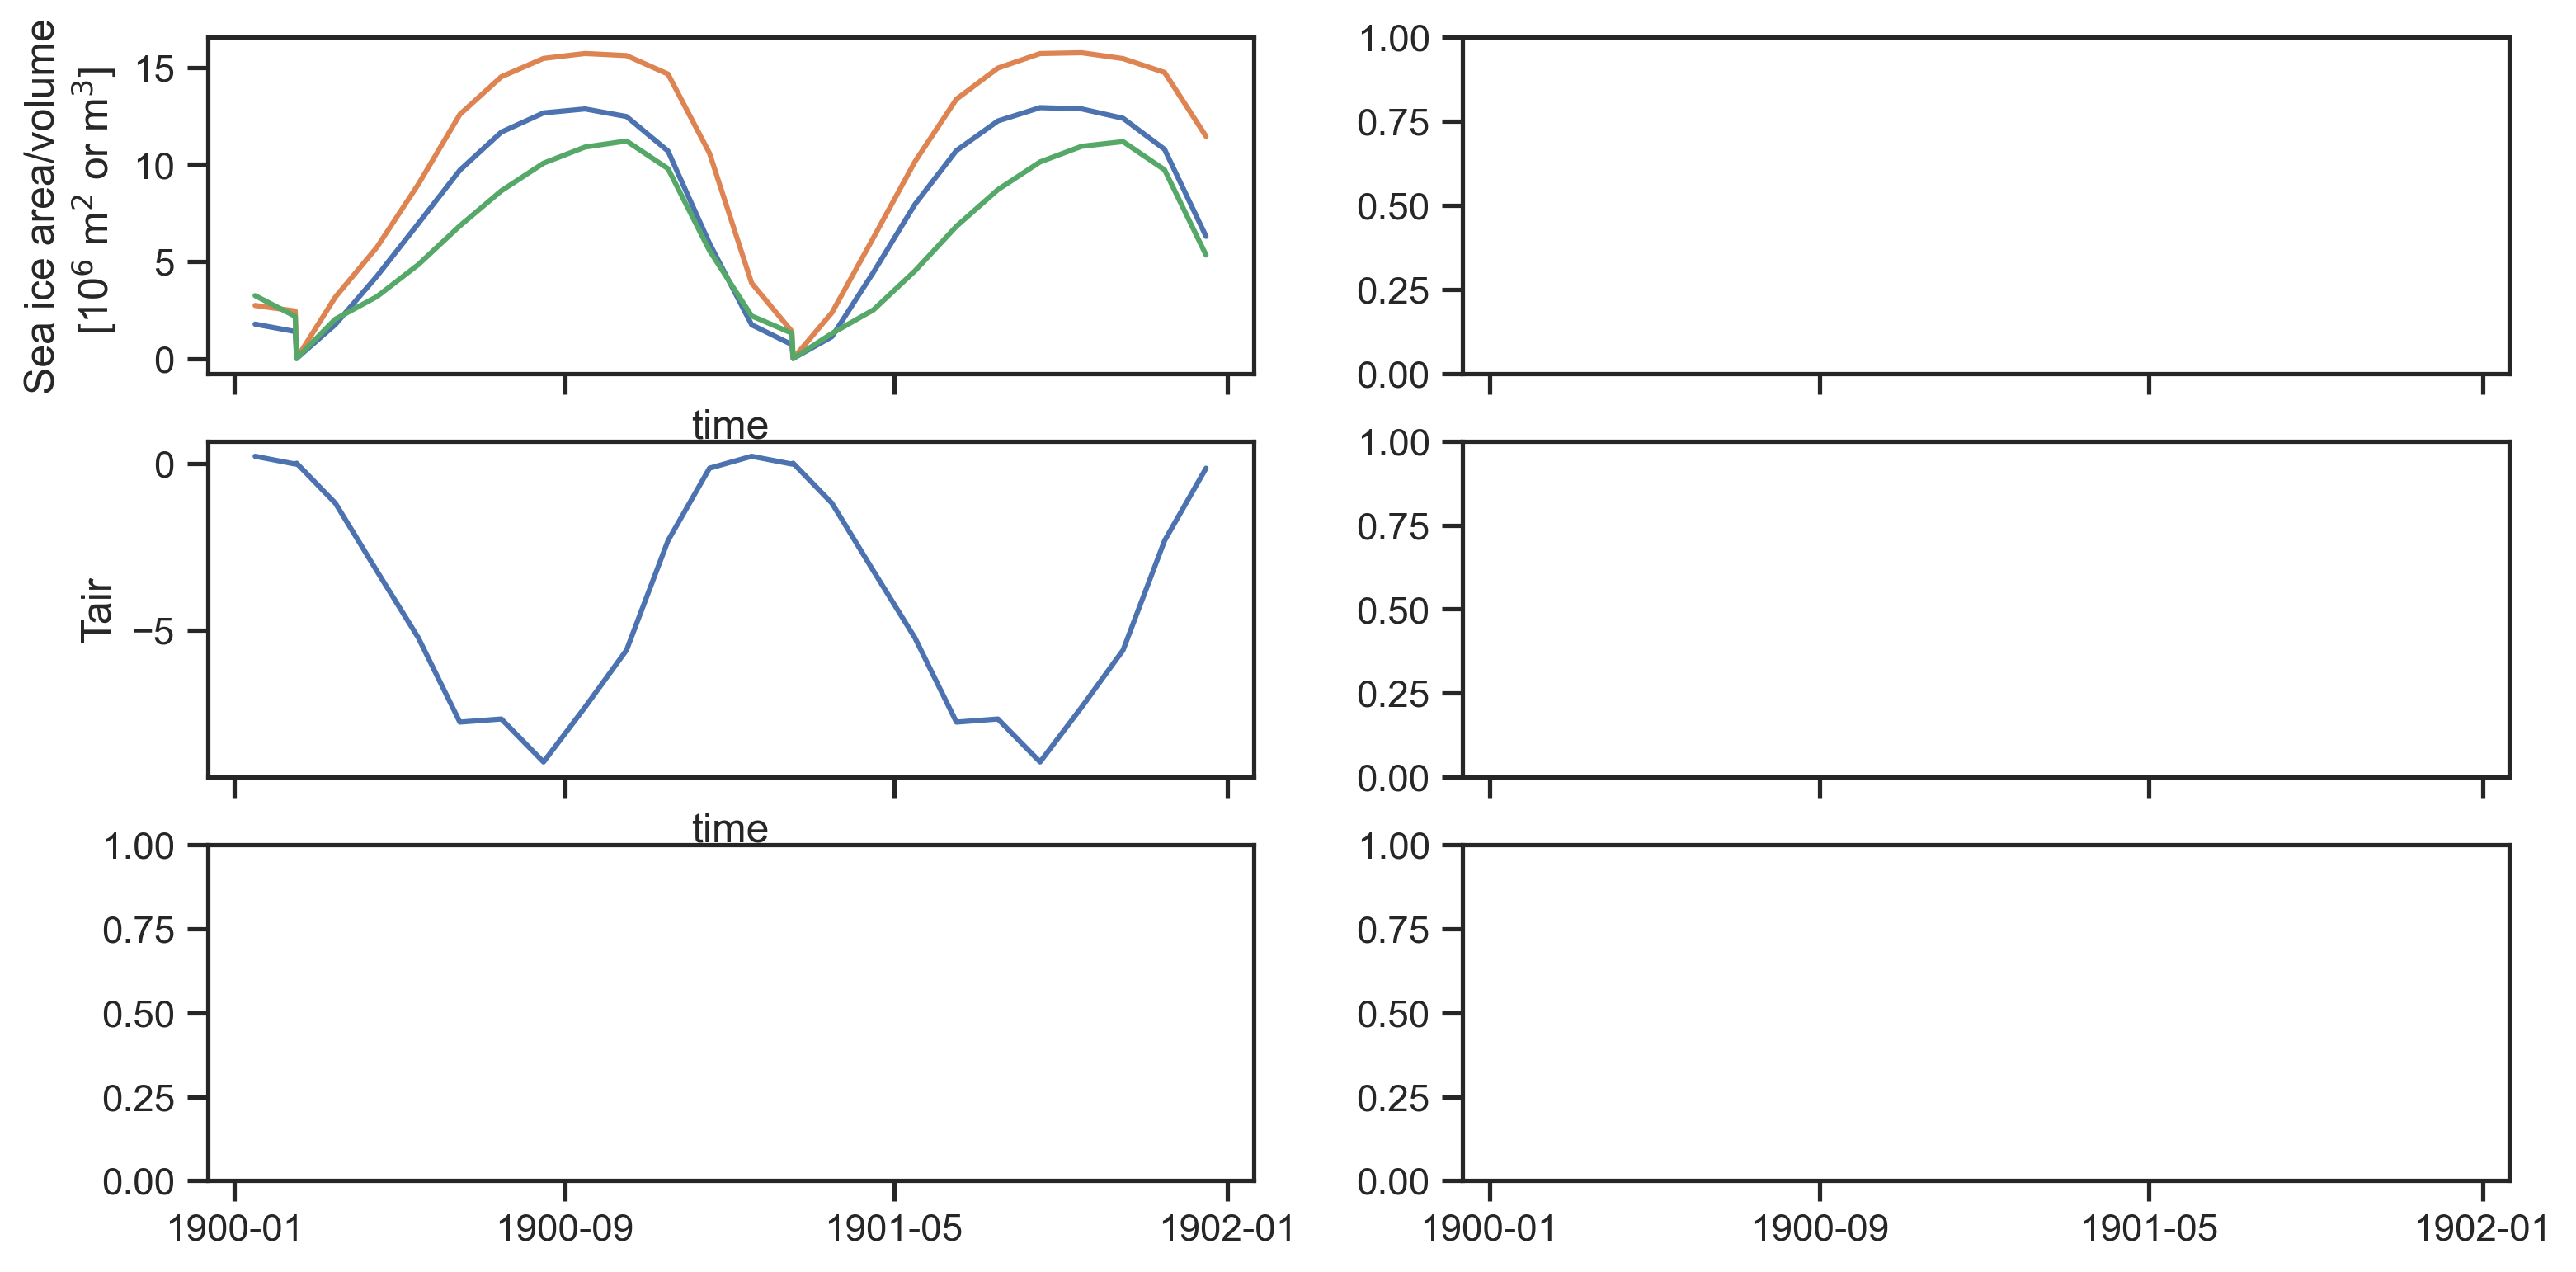

In [66]:
n = len(all_variables)
fig, axes = plt.subplots(3, 2, figsize=(12, 6), sharex=True)
axes = axes.flatten()

# Column 1
(1e-12*so_timeseries['sia']).plot(ax=axes[0], label='sia')
(1e-12*so_timeseries['sie']).plot(ax=axes[0], label='sie')
(1e-12*so_timeseries['siv']).plot(ax=axes[0], label='siv')
axes[0].set_ylabel('Sea ice area/volume\n [10$^6$ m$^2$ or m$^3$]')

so_timeseries['Tair'].plot(ax=axes[2], label='Tair')
so_timeseries['fsdrad'].plot(ax=axes[2], label='fsdrad')
axes[2].set_ylabel('[$^\circ$C or m]')

so_timeseries['tos'].plot(ax=axes[4], label='tos')
so_timeseries['wave_sig_ht'].plot(ax=axes[4], label='wave_sig_ht')
axes[4].set_ylabel('[$^\circ$C or m]')

# Column 2: Prognostic
so_timeseries['congel'].plot(ax=axes[1], label='congel')
so_timeseries['frazil'].plot(ax=axes[1], label='frazil')
axes[1].set_ylabel('[cm/day]')

so_timeseries['meltb'].plot(ax=axes[3], label='meltb')
so_timeseries['meltl'].plot(ax=axes[3], label='meltl')
so_timeseries['meltt'].plot(ax=axes[3], label='meltt')
axes[3].set_ylabel('[cm/day]')

so_timeseries['daidtt'].plot(ax=axes[5], label='daidtt')
so_timeseries['dvidtt'].plot(ax=axes[5], label='dvidtt')
axes[5].set_ylabel('[$\%$/day or cm/day]')

for ax in axes:
    ax.set_xlabel('')
    ax.legend()

axes[-1].set_xlabel("Time")
plt.subplots_adjust(hspace=0.4)
plt.show()

### Ocean variables

In [67]:
so_timeseries

<xarray.Dataset> Size: 4kB
Dimensions:  (time: 26)
Coordinates:
  * time     (time) object 208B 1900-01-16 12:00:00 ... 1901-12-16 12:00:00
Data variables: (12/18)
    aice     (time) float64 208B dask.array<chunksize=(1,), meta=np.ndarray>
    hi       (time) float64 208B dask.array<chunksize=(1,), meta=np.ndarray>
    congel   (time) float64 208B dask.array<chunksize=(1,), meta=np.ndarray>
    frazil   (time) float64 208B dask.array<chunksize=(1,), meta=np.ndarray>
    frzmlt   (time) float64 208B dask.array<chunksize=(1,), meta=np.ndarray>
    Tair     (time) float64 208B dask.array<chunksize=(1,), meta=np.ndarray>
    ...       ...
    mlotst   (time) float64 208B dask.array<chunksize=(1,), meta=np.ndarray>
    tos      (time) float64 208B dask.array<chunksize=(1,), meta=np.ndarray>
    sos      (time) float64 208B dask.array<chunksize=(1,), meta=np.ndarray>
    sia      (time) float64 208B dask.array<chunksize=(1,), meta=np.ndarray>
    sie      (time) float64 208B dask.array<chunksize=(1,), meta=np.ndarray>
    siv      (time) float64 208B dask.array<chunksize=(1,), meta=np.ndarray>

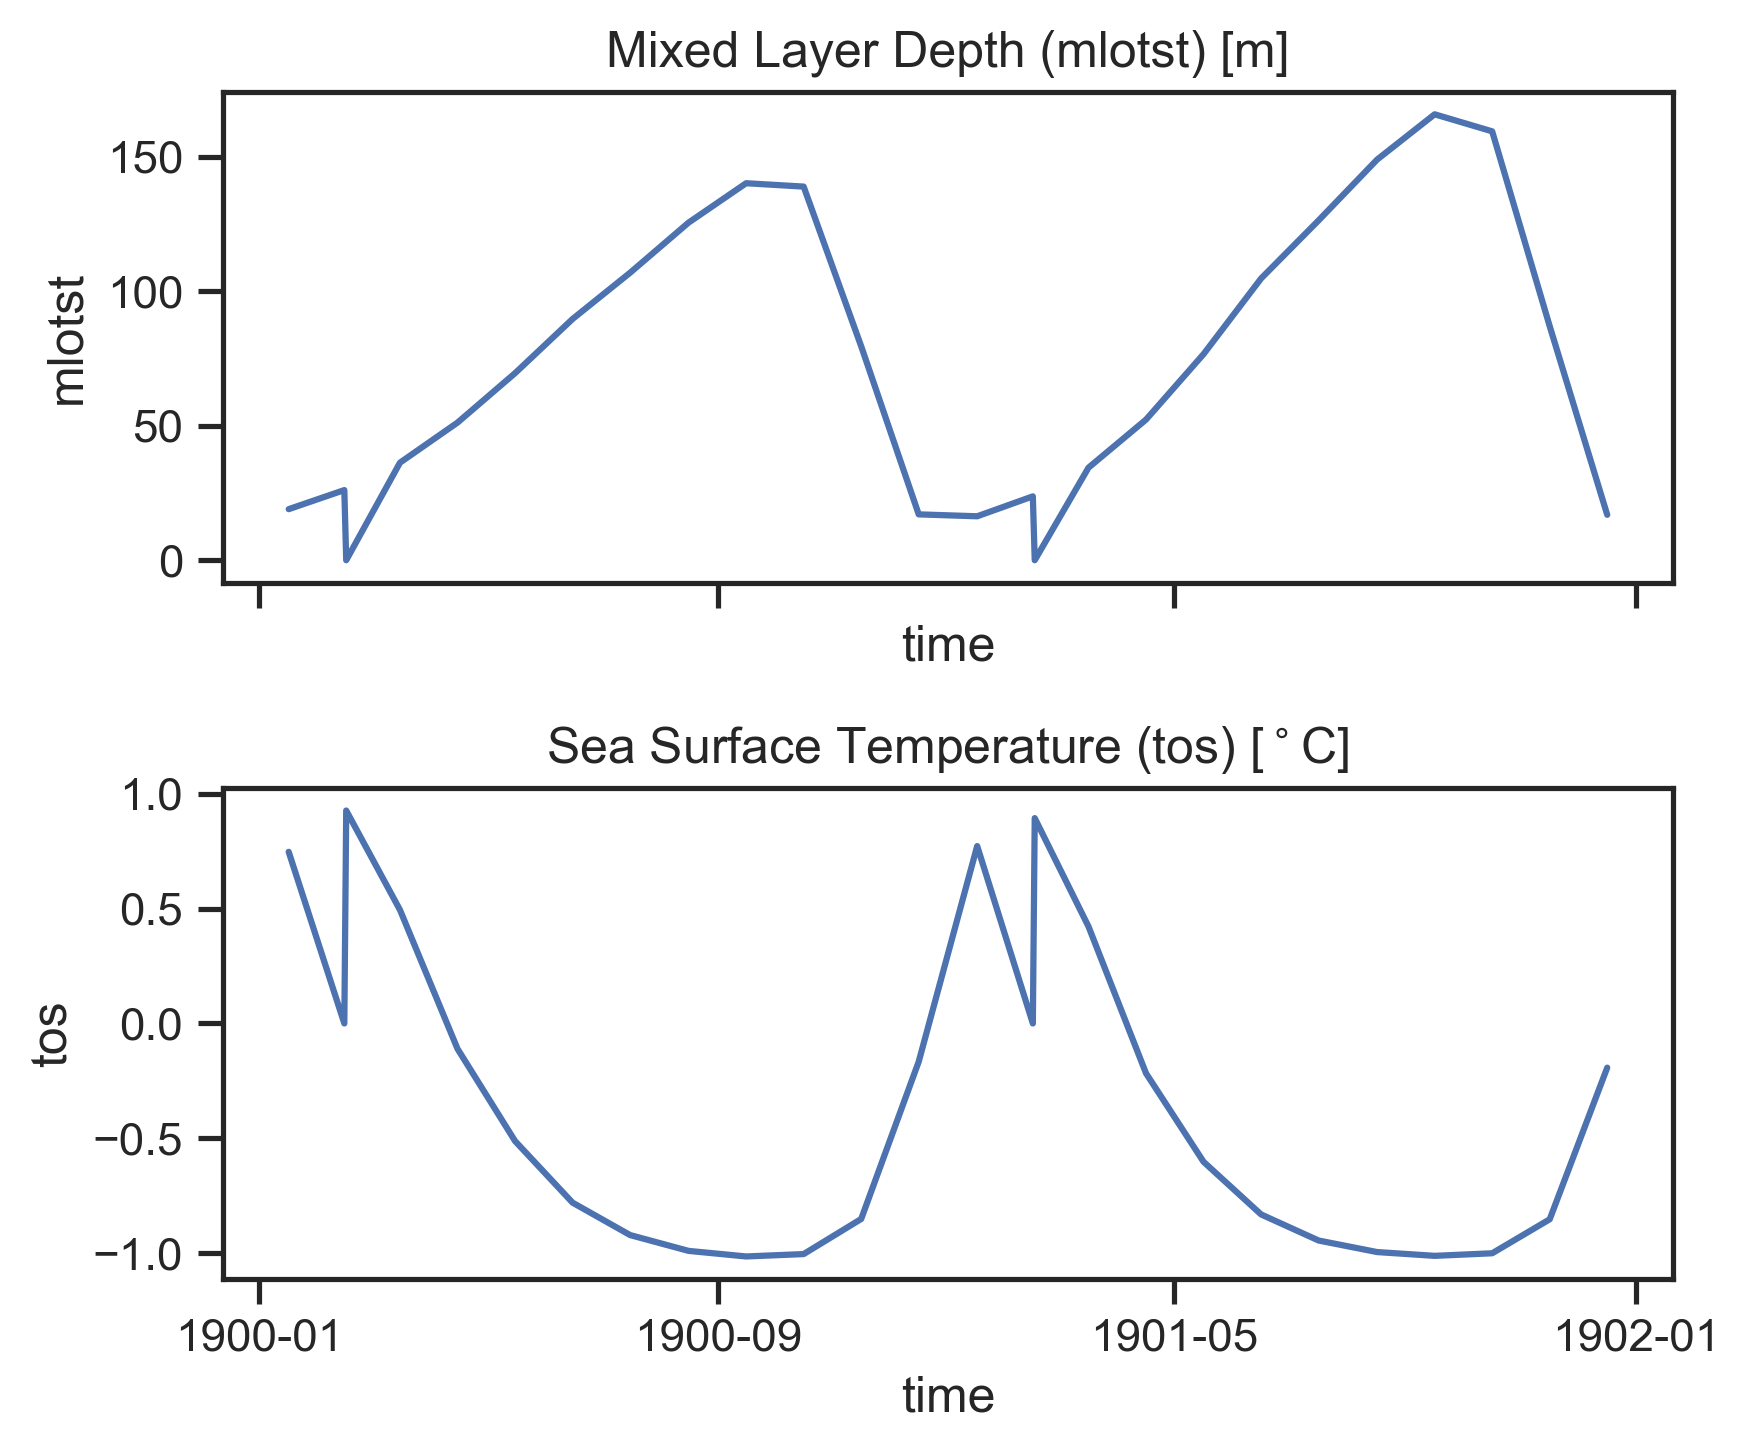

In [68]:
fig, axes = plt.subplots(2, 1, figsize=(6,5), sharex=True)

so_timeseries['mlotst'].plot(ax=axes[0])
axes[0].set_title("Mixed Layer Depth (mlotst) [m]")

so_timeseries['tos'].plot(ax=axes[1])
axes[1].set_title("Sea Surface Temperature (tos) [$^\circ$C]")

plt.tight_layout()
plt.show()

#### Fixing the plot axes

Notice that the white land-masked regions are distorted away from the coastlines in the Arctic in the above plot. This is because a tripolar grid is used, so the grid lines are not zonal and meridional north of 65N, and consequently the nominal 1D coordinates `xh` and `yh` are incorrect. To fix this we need to use 2d coordinates `geolon` and `geolat`.

We can get these coorindates from the intake-esm datastore. However, note that `geolon` and `geolat` contain NaNs in regions where processors were masked over land. Below we replace these NaNs with zeros so that the coordinates can be used for plotting.

In [69]:
coords = datastore.search(variable=["geolat", "geolon"]).to_dask().compute()
coords = coords.fillna(0.0)

zos = zos.assign_coords(coords)

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/intake_esm/source.py:308: ConcatenationWarning: Attempting to concatenate datasets without valid dimension coordinates: retaining only first dataset. Request valid dimension coordinate to silence this warning.
  warnings.warn(


NameError: name 'zos' is not defined

In [ ]:
proj = ccrs.PlateCarree()
fig, ax = plt.subplots(figsize=(15,6), subplot_kw=dict(projection=proj))

zos["zos"].isel(time=-1).plot(ax=ax, x="geolon", y="geolat")

ax.coastlines()
_ = ax.gridlines()
plt.savefig(plotfolder+'exampleout.png')

In [ ]:
client.close()